In [ ]:
!pip install xgboost imbalanced-learn --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Features saved to: /content/drive/MyDrive/Datasets/parkinsons_extracted_features_freq.csv
Fitting 5 folds for each of 20 candidates, totalling 100 fits

== Validation Set ==
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        35
           1       0.97      0.85      0.91        34

    accuracy                           0.91        69
   macro avg       0.92      0.91      0.91        69
weighted avg       0.92      0.91      0.91        69

AUC: 0.9815
Accuracy: 0.9130


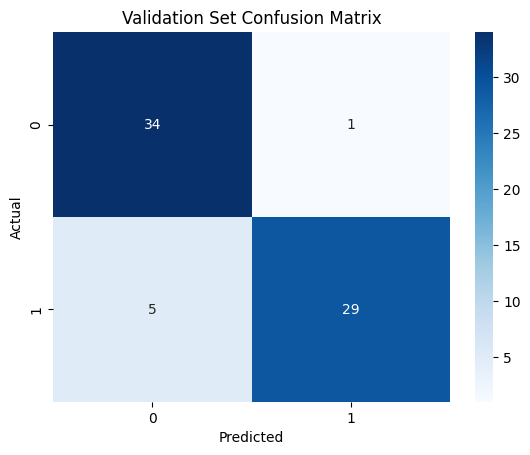


== Test Set ==
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        43
           1       0.98      0.93      0.95        43

    accuracy                           0.95        86
   macro avg       0.95      0.95      0.95        86
weighted avg       0.95      0.95      0.95        86

AUC: 0.9924
Accuracy: 0.9535


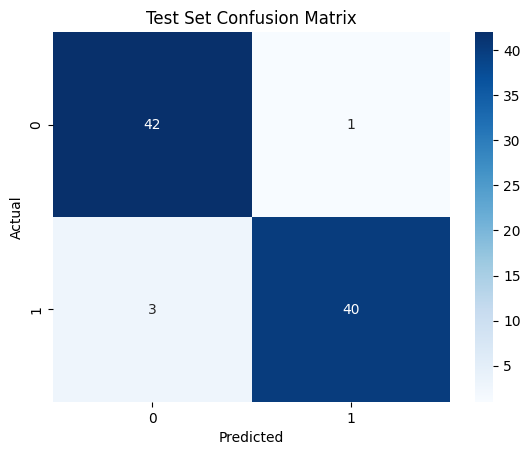

✅ Tuned XGBoost model saved to: /content/drive/MyDrive/parkinsons_xgb_model_freq.pkl


In [ ]:
# Install CatBoost
# 2. Imports
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/Datasets/Parkinson's GAIT"
output_csv = "/content/drive/MyDrive/Datasets/parkinsons_extracted_features_freq.csv"
model_path = "/content/drive/MyDrive/parkinsons_xgb_model_freq.pkl"

# 4. Feature Functions
def extract_features(signal):
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'range': np.ptp(signal),
        'energy': np.sum(signal**2),
        'entropy': -np.sum(np.nan_to_num(signal * np.log2(np.abs(signal) + 1e-9))),
        'skewness': skew(signal),
        'kurtosis': kurtosis(signal)
    }

def frequency_power(signal):
    freqs, power = welch(signal, fs=100)
    return {
        'freq_mean': np.mean(power),
        'freq_max': np.max(power),
        'freq_bandwidth': np.ptp(freqs[power > np.mean(power)]),
        'freq_entropy': -np.sum(np.nan_to_num(power * np.log2(power + 1e-9)))
    }

# 5. Feature Extraction
feature_rows = []

for fname in os.listdir(data_dir):
    if not fname.endswith(".txt") or "format" in fname or "SHA" in fname:
        continue

    try:
        label = 1 if "Pt" in fname else 0 if "Co" in fname else None
        if label is None:
            continue

        filepath = os.path.join(data_dir, fname)
        data = np.loadtxt(filepath)
        left = data[:, 1:9]
        right = data[:, 9:17]

        row = {"label": label, "filename": fname}
        for i in range(8):
            feats_left = {**extract_features(left[:, i]), **frequency_power(left[:, i])}
            feats_right = {**extract_features(right[:, i]), **frequency_power(right[:, i])}
            for k, v in feats_left.items():
                row[f"L{i+1}_{k}"] = v
            for k, v in feats_right.items():
                row[f"R{i+1}_{k}"] = v

        feature_rows.append(row)
    except Exception as e:
        print(f"Skipping {fname}: {e}")

df = pd.DataFrame(feature_rows)
df.to_csv(output_csv, index=False)
print(f"✅ Features saved to: {output_csv}")

# 6. Train/Test/Validation Split
X = df.drop(columns=["label", "filename"])
y = df["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

X_temp, X_test, y_temp, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# 7. Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=2
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
best_model.fit(X_train, y_train)

# 8. Evaluation Function
def evaluate(name, model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    print(f"\n== {name} ==")
    print(classification_report(y, y_pred))
    print(f"AUC: {roc_auc_score(y, y_proba):.4f}")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 9. Final Evaluation
evaluate("Validation Set", best_model, X_val, y_val)
evaluate("Test Set", best_model, X_test, y_test)

# 10. Save Model
joblib.dump(best_model, model_path)
print(f"✅ Tuned XGBoost model saved to: {model_path}")